In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

Define current wells and desires depth intervals for each well



In [2]:
wells = ["CCS1", "VW1"]
#these are absolute depth intervals that we have data for
depth_intervals = {"CCS1" : [3200, 7237],
                   "VW1" : [4226, 7270],
                   "VW2" : [2600, 7237]
}
depth_intervals_for_plots = {"CCS1" : [3200, 7237],
                   "VW1" : [4226, 7270],
                   "VW2" : [2600, 7237]
}

formations = [ #important that these are kept in order
        "Eau Claire",
        "Mt. Simon E",
        "Mt. Simon D",
        "Mt. Simon C",
        "Mt. Simon B",
        "Mt. Simon A",
        "Argenta",
        "Precambrian"
    ]

FORMATION_PATH = "REU Project/Excel Sheets/Rock Formation Depths.xlsx"
FMI_LOG_PATH = "REU Project/Excel Sheets/FMI Logs.xlsx"
RAW_DIR = "REU Project/Data/Raw CSV Files/raw_"
LABELS_DIR = "REU Project/Data/labels/"

Filter intervals based on rock formations chosen

In [3]:
formation_pd = pd.read_excel(FORMATION_PATH, header=0)
for well in wells:
  filtered_formations = formation_pd[formation_pd["Well"] == well]
  min_dep = float(filtered_formations[
      filtered_formations["Structure"] == formations[0]]["Min Dept"])
  max_dep = float(filtered_formations[
      filtered_formations["Structure"] == formations[-1]]["Max Dept"])

  curr_range = depth_intervals_for_plots[well]
  if min_dep > 0 :
    curr_range[0] = min_dep
  if max_dep < np.inf:
    curr_range[1] = max_dep
  depth_intervals_for_plots[well] = curr_range

print(depth_intervals)
print(depth_intervals_for_plots)

{'CCS1': [3200, 7237], 'VW1': [4226, 7270], 'VW2': [2600, 7237]}
{'CCS1': [3200, 7237], 'VW1': [4226, 7270], 'VW2': [2600, 7237]}


Read Excel File

In [4]:
dfs = {}
for well in wells:
  dfs[well] = pd.read_excel(FMI_LOG_PATH, sheet_name = well)

Extract Depth Intervals For Each Wells That Contain Fractures

In [5]:
frac_dic = {}
minmax_dic = {}
for well, df in dfs.items():
  min_d = 800000 #need to initialize greater than biggest depth
  max_d = 0
  depths = []
  for idx, row in df.iterrows():
    top = row["Top Depth"]
    bottom = row["Bottom Depth"]
    depths.append((top, bottom)) #top depth is a lower number than bottom depth

    min_d = min(min_d, top)
    max_d = max(max_d, bottom)
    minmax_dic[well] = [min_d, max_d]
  frac_dic[well] = depths

Assigns whether a depth is present at each depth given a list of depths

In [6]:
def find_fractures(well, depths):
  fractures_present = []
  frac_intervals = frac_dic[well]
  for depth in depths:
    crack = False
    #loop through to see if depth fits into any of the intervals
    for i in range(len(frac_intervals)):
      if depth >= frac_intervals[i][0] and depth <= frac_intervals[i][1]:
        fractures_present.append(1)
        crack = True
        break
    if not crack:
      fractures_present.append(0)
  return fractures_present

Plot Depths

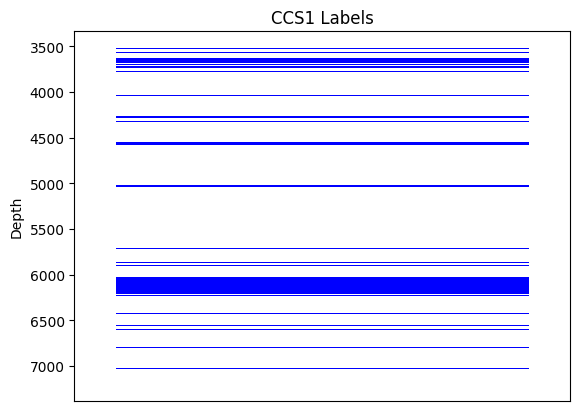

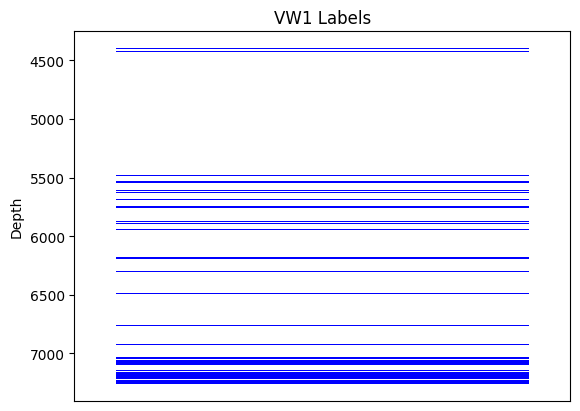

In [7]:
for well in wells:
  #depth range that spans all depths in FMI log and increases by .5 each step
  dep_range = np.arange(depth_intervals_for_plots[well][0],
                        depth_intervals_for_plots[well][1],
                        0.5)
  labels = pd.DataFrame({"DEPT": dep_range,
                         "HAS_FRAC" : find_fractures(well, dep_range)})

  plt.title(well + " Labels")
  plt.ylabel("Depth")
  for idx, row in labels.iterrows():
    if row["HAS_FRAC"] == 1:
      plt.barh(row["DEPT"], 1, color="blue")
  plt.xticks([])
  plt.xlim(-0.1,1.1)
  plt.gca().invert_yaxis()
  plt.show()

For each depth in the datalogs file, assign whether fracture is present and write to file

CCS1 : 5101.0 -> 7209.0


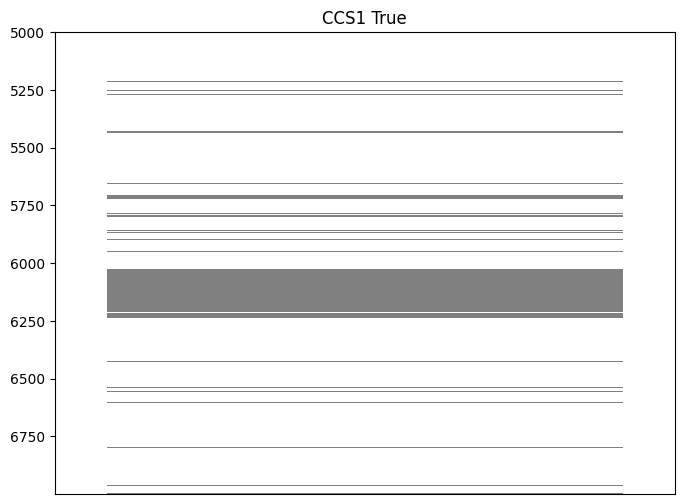

VW1 : 5229.0 -> 7228.0


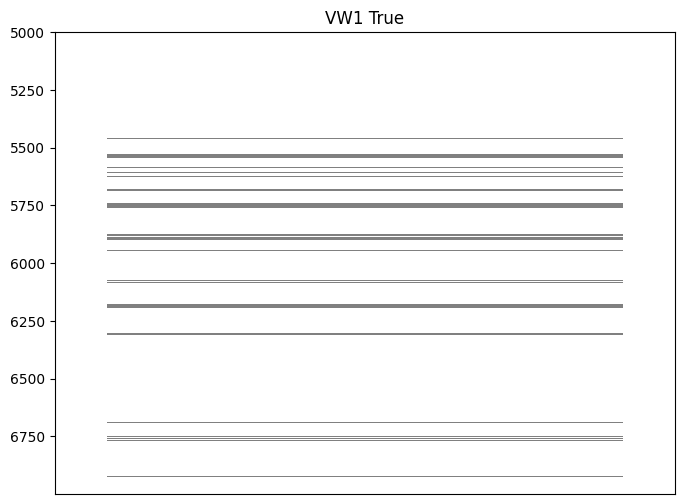

In [8]:
for well in wells:
  df = pd.read_csv(RAW_DIR + well + ".csv")

  input_depths = df["DEPT"]
  min_val, max_val = depth_intervals[well]
  filtered_df = df[(df['DEPT'] >= min_val) & (df['DEPT'] <= max_val)]
  dep_range = filtered_df["DEPT"]
  print(f"{well} : {dep_range.min()} -> {dep_range.max()}")
  labels = pd.DataFrame({"DEPT": dep_range,
                         "HAS_FRAC" : find_fractures(well, dep_range)})

  # write data to file
  filename = LABELS_DIR +"/" + "label_" + well + '.csv'
  labels.to_csv(filename, index=False)

  #plot results
  plt.figure(figsize=(8, 6))
  plt.title(well + " True")
  #plt.ylabel("Depth")
  for idx, row in labels.iterrows():
    if row["HAS_FRAC"] == 1:
      plt.barh(row["DEPT"], 1, color="gray")
  plt.xticks([])
  plt.xlim(-0.1,1.1)
  mind = math.floor(int(dep_range.min()) / 250) * 250
  maxd = math.floor(int(dep_range.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.gca().invert_yaxis()
  plt.show()

Plot Label Distribution

CCS1 : 5101.0 -> 7209.0
VW1 : 5229.0 -> 7228.0


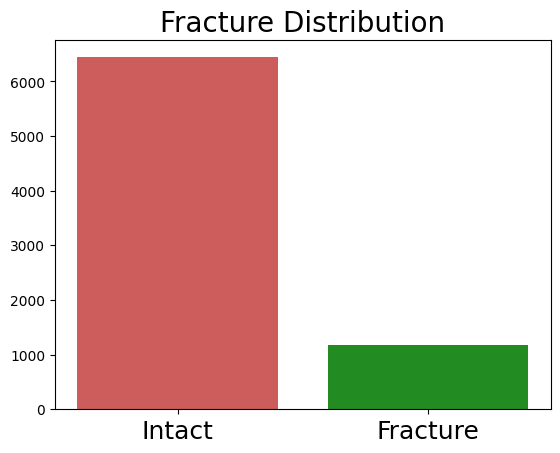

In [10]:
sum_0 = 0
sum_1 = 0
for well in wells:
  df = pd.read_csv(RAW_DIR + well + ".csv")

  input_depths = df["DEPT"]
  min_val, max_val = depth_intervals[well]
  filtered_df = df[(df['DEPT'] >= min_val) & (df['DEPT'] <= max_val)]
  dep_range = filtered_df["DEPT"]
  print(f"{well} : {dep_range.min()} -> {dep_range.max()}")
  labels = pd.DataFrame({"DEPT": dep_range,
                         "HAS_FRAC" : find_fractures(well, dep_range)})
  labels_list = list(labels["HAS_FRAC"])

  sum_1 += sum(labels_list)
  sum_0 += len(labels_list) - sum_1

plt.title("Fracture Distribution", fontsize=20)
plt.bar([0, 1], [sum_0, sum_1], color = ["indianred", "forestgreen"])
plt.xticks([0,1], ['Intact', 'Fracture'], fontsize=18)
#plt.xticks([])
#plt.savefig('FracDistributionPlot.png', format='png', dpi=1200)
plt.show()
